## 📦 Installazione Pacchetti

Installazione di tutte le librerie necessarie per il progetto.

In [1]:
# Installazione pacchetti necessari
import sys
import subprocess

packages = [
    'transformers>=4.30.0',
    'datasets',
    'torch',
    'accelerate',
    'sentencepiece',
    'huggingface-hub',
    'peft',  # ← LoRA library
    'tqdm',
    'scikit-learn'
]

print("📦 Installazione pacchetti (incluso PEFT per LoRA)...")
for package in packages:
    try:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', package])
    except:
        print(f"⚠ Errore nell'installazione di {package}")

print("✅ Pacchetti installati con successo!")

📦 Installazione pacchetti (incluso PEFT per LoRA)...
⚠ Errore nell'installazione di datasets
⚠ Errore nell'installazione di huggingface-hub
⚠ Errore nell'installazione di peft
✅ Pacchetti installati con successo!


## 🔑 Autenticazione HuggingFace

Configurazione del token HuggingFace.
- **VS Code**: Imposta la variabile d'ambiente `HF_TOKEN`
- **Google Colab**: Usa Colab Secrets

In [1]:
from huggingface_hub import login
import os

# Get HuggingFace token from environment variable
# Per impostare il token: set HF_TOKEN=your_token_here (Windows PowerShell)
# Oppure su Google Colab: userdata.get('HF_TOKEN')
try:
    # Prova prima con variabile d'ambiente (per VS Code)
    HF_TOKEN = os.getenv('HF_TOKEN')

    if HF_TOKEN is None:
        # Fallback per Google Colab
        try:
            from google.colab import userdata
            HF_TOKEN = userdata.get('HF_TOKEN')
        except:
            print("⚠ HF_TOKEN non trovato. Puoi impostarlo con:")
            print("  - Windows: $env:HF_TOKEN='your_token'")
            print("  - Linux/Mac: export HF_TOKEN='your_token'")
            print("  - Google Colab: Aggiungi HF_TOKEN ai Secrets")
            HF_TOKEN = None

    if HF_TOKEN:
        # Login to HuggingFace
        login(token=HF_TOKEN)
        print("✅ Successfully authenticated with HuggingFace!")
    else:
        print("⚠ Continuando senza autenticazione HuggingFace.")
        print("  Alcuni modelli potrebbero non essere accessibili.")

except Exception as e:
    print(f"⚠ Errore durante l'autenticazione: {e}")
    print("  Continuando senza autenticazione HuggingFace.")

✅ Successfully authenticated with HuggingFace!


In [2]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers & PEFT
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    pipeline,
    AutoModel,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    get_linear_schedule_with_warmup
)
from peft import LoraConfig, get_peft_model, PeftModel, prepare_model_for_kbit_training

# PyTorch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set seed per riproducibilità
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Using device: {device}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

🖥️  Using device: cuda
🎮 GPU: NVIDIA A100-SXM4-80GB
💾 GPU Memory: 85.17 GB


## ⚙️ Configurazione Dataset

Configurazione degli URL per il caricamento dei dati da GitHub.

In [3]:
# Configuration
TRACK = "track_a"
SUBTASK = "3"  # Subtask 3 per Quadruplet Extraction (DimASQP)
LANGUAGE = "eng"  # Lingua: eng, jpn, rus, tat, ukr, zho
DOMAIN = "restaurant"  # Dominio: restaurant, laptop, hotel

# Build GitHub URLs
BASE_URL = "https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset"
TRAIN_URL = f"{BASE_URL}/{TRACK}/subtask_{SUBTASK}/{LANGUAGE}/{LANGUAGE}_{DOMAIN}_train_alltasks.jsonl"

# Display configuration
print("="*60)
print("📊 CONFIGURAZIONE DATASET")
print("="*60)
print(f"Track:     {TRACK}")
print(f"Subtask:   {SUBTASK} (Quadruplet Extraction - DimASQP)")
print(f"Language:  {LANGUAGE}")
print(f"Domain:    {DOMAIN}")
print(f"\nTrain URL: {TRAIN_URL}")
print("="*60)

📊 CONFIGURAZIONE DATASET
Track:     track_a
Subtask:   3 (Quadruplet Extraction - DimASQP)
Language:  eng
Domain:    restaurant

Train URL: https://raw.githubusercontent.com/DimABSA/DimABSA2026/main/task-dataset/track_a/subtask_3/eng/eng_restaurant_train_alltasks.jsonl


## 1. Setup e Import Librerie

In [4]:
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Transformers
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForSequenceClassification,
    BitsAndBytesConfig,
    pipeline,
    AutoModel
)

# PyTorch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim import AdamW

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Set seed per riproducibilità
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB


## 2. Analisi del Dataset

In [5]:
def load_jsonl_from_url(url: str) -> List[Dict]:
    """
    Carica dati JSONL da un URL GitHub.

    Args:
        url: URL del file JSONL

    Returns:
        Lista di dizionari
    """
    import urllib.request

    try:
        print(f"⏳ Caricamento da {url.split('/')[-1]}...")
        with urllib.request.urlopen(url) as response:
            data = response.read().decode('utf-8')
            items = [json.loads(line) for line in data.strip().split('\n') if line.strip()]
        print(f"✓ Caricati {len(items)} esempi")
        return items
    except Exception as e:
        print(f"❌ Errore nel caricamento da {url}: {e}")
        raise

# Caricamento dati
train_data = load_jsonl_from_url(TRAIN_URL)
print(f"\n{'='*60}")
print(f"DATASET CARICATO")
print(f"{'='*60}")
print(f"Numero di esempi nel training set: {len(train_data)}")
print(f"\nEsempio di dato:")
print(json.dumps(train_data[0], indent=2))


⏳ Caricamento da eng_restaurant_train_alltasks.jsonl...
✓ Caricati 2284 esempi

DATASET CARICATO
Numero di esempi nel training set: 2284

Esempio di dato:
{
  "ID": "rest16_quad_dev_1",
  "Text": "ca n ' t wait wait for my next visit .",
  "Quadruplet": [
    {
      "Aspect": "NULL",
      "Opinion": "NULL",
      "Category": "RESTAURANT#GENERAL",
      "VA": "6.75#6.38"
    }
  ]
}


## 🔄 Gestione Split Dataset: LLM Extraction vs VA Training

**Obiettivo**: Separare chiaramente:
- **LLM Extraction Split**: Per testare LLAMA su train/val/test mantenendo consistenza
- **VA Training Dataset**: Usa sempre gli stessi ID record originali per training BERT

Questo permette di:
1. Testare l'estrazione di LLAMA su subset diversi (train/val/test)
2. Mantenere coerenza negli ID dei record quando si traina il modello VA
3. Garantire riproducibilità e confrontabilità dei risultati

In [7]:
def create_dataset_splits(data: List[Dict],
                         train_ratio: float = 0.7,
                         val_ratio: float = 0.15,
                         test_ratio: float = 0.15,
                         seed: int = 42):
    """
    Crea split consistenti per train/val/test mantenendo gli ID originali.

    Args:
        data: Dataset completo
        train_ratio: Percentuale per training set
        val_ratio: Percentuale per validation set
        test_ratio: Percentuale per test set
        seed: Random seed per riproducibilità

    Returns:
        Tuple (train_data, val_data, test_data) con ID originali preservati
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Le proporzioni devono sommare a 1.0"

    # Shuffle con seed fisso per riproducibilità
    np.random.seed(seed)
    indices = np.random.permutation(len(data))

    # Calcola dimensioni degli split
    n_train = int(len(data) * train_ratio)
    n_val = int(len(data) * val_ratio)

    # Split degli indici
    train_indices = indices[:n_train]
    val_indices = indices[n_train:n_train + n_val]
    test_indices = indices[n_train + n_val:]

    # Crea i subset mantenendo gli ID originali
    train_split = [data[i] for i in train_indices]
    val_split = [data[i] for i in val_indices]
    test_split = [data[i] for i in test_indices]

    # Salva gli indici per riferimento futuro
    split_info = {
        'train_indices': train_indices.tolist(),
        'val_indices': val_indices.tolist(),
        'test_indices': test_indices.tolist(),
        'train_ids': [item['ID'] for item in train_split],
        'val_ids': [item['ID'] for item in val_split],
        'test_ids': [item['ID'] for item in test_split]
    }

    return train_split, val_split, test_split, split_info


# Crea gli split
print("\n" + "="*80)
print("📊 CREAZIONE SPLIT DATASET (Train/Val/Test)")
print("="*80)

train_split_data, val_split_data, test_split_data, split_info = create_dataset_splits(
    data=train_data,
    train_ratio=0.7,
    val_ratio=0.15,
    test_ratio=0.15,
    seed=SEED
)

print(f"\n✅ Split creati con successo:")
print(f"  - Training set:   {len(train_split_data)} esempi ({len(train_split_data)/len(train_data)*100:.1f}%)")
print(f"  - Validation set: {len(val_split_data)} esempi ({len(val_split_data)/len(train_data)*100:.1f}%)")
print(f"  - Test set:       {len(test_split_data)} esempi ({len(test_split_data)/len(train_data)*100:.1f}%)")
print(f"\n📋 ID preservati:")
print(f"  - Train IDs: {train_split_data[0]['ID']}, {train_split_data[1]['ID']}, ...")
print(f"  - Val IDs:   {val_split_data[0]['ID']}, {val_split_data[1]['ID']}, ...")
print(f"  - Test IDs:  {test_split_data[0]['ID']}, {test_split_data[1]['ID']}, ...")
print("="*80)


📊 CREAZIONE SPLIT DATASET (Train/Val/Test)

✅ Split creati con successo:
  - Training set:   1598 esempi (70.0%)
  - Validation set: 342 esempi (15.0%)
  - Test set:       344 esempi (15.1%)

📋 ID preservati:
  - Train IDs: rest16_quad_test_213, rest16_quad_train_1432, ...
  - Val IDs:   rest16_quad_dev_80, rest16_quad_train_419, ...
  - Test IDs:  rest16_quad_train_413, rest16_quad_test_300, ...


## 🔥 LoRA Fine-tuning Configuration

Prima di usare LLAMA per l'estrazione, lo fine-tuniamo con **LoRA** (Low-Rank Adaptation) sui nostri dati di training per migliorare le performance.

In [8]:
def create_prompt_for_training(text: str) -> str:
    """Crea prompt few-shot per estrazione AOC (versione training)."""
    prompt = f"""### TASK
You are an aspect-category-opinion extraction system for restaurant reviews. Extract triplets and return ONLY a valid JSON array.

### RULES:
1. ASPECT = target entity/attribute. Use "NULL" if implicit.
2. CATEGORY = Entity#Attribute in UPPERCASE (e.g., "FOOD#QUALITY"). NEVER NULL.
3. OPINION = sentiment word/phrase from text. Use "NULL" if implicit.
4. Return ONLY the JSON array, nothing else.

VALID CATEGORIES:
- Entities: RESTAURANT, FOOD, DRINKS, AMBIENCE, SERVICE, LOCATION
- Attributes: GENERAL, PRICES, QUALITY, STYLE_OPTIONS, MISCELLANEOUS

### EXAMPLES:

Text: "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome."
[{{"aspect": "spicy tuna roll", "category": "FOOD#QUALITY", "opinion": "unusually good"}}, {{"aspect": "rock shrimp tempura", "category": "FOOD#QUALITY", "opinion": "awesome"}}]

Text: "we love the pink pony."
[{{"aspect": "pink pony", "category": "RESTAURANT#GENERAL", "opinion": "love"}}]

Text: "the food here is rather good, but only if you like to wait for it."
[{{"aspect": "food", "category": "FOOD#QUALITY", "opinion": "rather good"}}, {{"aspect": "NULL", "category": "SERVICE#GENERAL", "opinion": "NULL"}}]

### INPUT
Text: "{text}"

### OUTPUT
"""
    return prompt

# Test prompt
test_text = "The food was amazing but the service was slow."
print("📝 Esempio di prompt per training:")
print("="*80)
print(create_prompt_for_training(test_text))
print("="*80)

📝 Esempio di prompt per training:
### TASK
You are an aspect-category-opinion extraction system for restaurant reviews. Extract triplets and return ONLY a valid JSON array.

### RULES:
1. ASPECT = target entity/attribute. Use "NULL" if implicit.
2. CATEGORY = Entity#Attribute in UPPERCASE (e.g., "FOOD#QUALITY"). NEVER NULL.
3. OPINION = sentiment word/phrase from text. Use "NULL" if implicit.
4. Return ONLY the JSON array, nothing else.

VALID CATEGORIES:
- Entities: RESTAURANT, FOOD, DRINKS, AMBIENCE, SERVICE, LOCATION
- Attributes: GENERAL, PRICES, QUALITY, STYLE_OPTIONS, MISCELLANEOUS

### EXAMPLES:

Text: "the spicy tuna roll was unusually good and the rock shrimp tempura was awesome."
[{"aspect": "spicy tuna roll", "category": "FOOD#QUALITY", "opinion": "unusually good"}, {"aspect": "rock shrimp tempura", "category": "FOOD#QUALITY", "opinion": "awesome"}]

Text: "we love the pink pony."
[{"aspect": "pink pony", "category": "RESTAURANT#GENERAL", "opinion": "love"}]

Text: "the food

In [9]:
class AOCDatasetForLoRA(Dataset):
    """Dataset per training AOC extraction con LoRA."""

    def __init__(self, data: List[Dict], tokenizer, max_length: int = 512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # Input: prompt con il testo
        prompt = create_prompt_for_training(item['Text'])

        # Target: JSON output con AOC
        target_aocs = [
            {
                "aspect": q['Aspect'],
                "category": q['Category'],
                "opinion": q['Opinion']
            }
            for q in item['Quadruplet']
        ]
        target_json = json.dumps(target_aocs)

        # Testo completo: prompt + target
        full_text = prompt + target_json

        # Tokenizza
        encoding = self.tokenizer(
            full_text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        # Labels: copia di input_ids, ma maschera il prompt
        labels = encoding['input_ids'].clone()

        # Calcola lunghezza del prompt (da mascherare)
        prompt_encoding = self.tokenizer(
            prompt,
            truncation=True,
            return_tensors='pt'
        )
        prompt_length = prompt_encoding['input_ids'].shape[1]

        # Maschera il prompt (loss calcolata solo sul target JSON)
        labels[:, :prompt_length] = -100

        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': labels.squeeze()
        }

print("✅ Dataset class per LoRA training definita")

✅ Dataset class per LoRA training definita


In [10]:
# Configurazione modello LLAMA con LoRA
MODEL_NAME = "meta-llama/Llama-3.2-3B-Instruct"

print("\n" + "="*80)
print("🤖 CARICAMENTO MODELLO LLAMA CON LoRA")
print("="*80)

# Carica tokenizer
print("⏳ Caricamento tokenizer...")
lora_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
lora_tokenizer.padding_side = 'left'
if lora_tokenizer.pad_token is None:
    lora_tokenizer.pad_token = lora_tokenizer.eos_token
print("✓ Tokenizer caricato")

# Carica modello base
print("\n⏳ Caricamento modello base...")
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
print("✓ Modello base caricato")

# Configura LoRA
print("\n⚙️  Configurazione LoRA...")
lora_config = LoraConfig(
    r=16,                    # Rank delle matrici LoRA
    lora_alpha=32,           # Scaling factor
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],  # Attention layers
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM"
)

# Applica LoRA al modello
lora_model = get_peft_model(base_model, lora_config)
lora_model.print_trainable_parameters()

print("\n✅ Modello LoRA pronto per il training!")
print("="*80)


🤖 CARICAMENTO MODELLO LLAMA CON LoRA
⏳ Caricamento tokenizer...


tokenizer_config.json:   0%|          | 0.00/54.5k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

✓ Tokenizer caricato

⏳ Caricamento modello base...


config.json:   0%|          | 0.00/878 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.46G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

✓ Modello base caricato

⚙️  Configurazione LoRA...
trainable params: 9,175,040 || all params: 3,221,924,864 || trainable%: 0.2848

✅ Modello LoRA pronto per il training!


In [11]:
# Crea dataset per LoRA training
print("\n📊 Creazione dataset per LoRA training...")
lora_train_dataset = AOCDatasetForLoRA(train_split_data, lora_tokenizer, max_length=512)
lora_val_dataset = AOCDatasetForLoRA(val_split_data, lora_tokenizer, max_length=512)

print(f"✓ Train dataset: {len(lora_train_dataset)} esempi")
print(f"✓ Val dataset:   {len(lora_val_dataset)} esempi")

# Test dataset
print("\n🔍 Test dataset:")
sample = lora_train_dataset[0]
print(f"Input IDs shape:      {sample['input_ids'].shape}")
print(f"Attention Mask shape: {sample['attention_mask'].shape}")
print(f"Labels shape:         {sample['labels'].shape}")
print(f"\nPrimi 10 label: {sample['labels'][:10].tolist()}")
print(f"(Note: -100 = prompt mascherato, loss non calcolata)")


📊 Creazione dataset per LoRA training...
✓ Train dataset: 1598 esempi
✓ Val dataset:   342 esempi

🔍 Test dataset:
Input IDs shape:      torch.Size([512])
Attention Mask shape: torch.Size([512])
Labels shape:         torch.Size([512])

Primi 10 label: [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100]
(Note: -100 = prompt mascherato, loss non calcolata)


In [12]:
# Hyperparameters per LoRA training
LORA_BATCH_SIZE = 4
LORA_GRADIENT_ACCUMULATION_STEPS = 4  # Effective batch size = 16
LORA_LEARNING_RATE = 1e-4
LORA_NUM_EPOCHS = 3
LORA_WARMUP_STEPS = 100
LORA_LOGGING_STEPS = 50
LORA_EVAL_STEPS = 200
LORA_SAVE_STEPS = 500
LORA_OUTPUT_DIR = "./lora_checkpoints"

print("\n" + "="*80)
print("🎓 CONFIGURAZIONE LoRA TRAINING")
print("="*80)
print(f"Batch size:                {LORA_BATCH_SIZE}")
print(f"Gradient accumulation:     {LORA_GRADIENT_ACCUMULATION_STEPS}")
print(f"Effective batch size:      {LORA_BATCH_SIZE * LORA_GRADIENT_ACCUMULATION_STEPS}")
print(f"Learning rate:             {LORA_LEARNING_RATE}")
print(f"Num epochs:                {LORA_NUM_EPOCHS}")
print(f"Warmup steps:              {LORA_WARMUP_STEPS}")
print(f"Total training steps:      {len(lora_train_dataset) // (LORA_BATCH_SIZE * LORA_GRADIENT_ACCUMULATION_STEPS) * LORA_NUM_EPOCHS}")
print(f"Output directory:          {LORA_OUTPUT_DIR}")
print("="*80)


🎓 CONFIGURAZIONE LoRA TRAINING
Batch size:                4
Gradient accumulation:     4
Effective batch size:      16
Learning rate:             0.0001
Num epochs:                3
Warmup steps:              100
Total training steps:      297
Output directory:          ./lora_checkpoints


## 🚀 LoRA Training Loop

In [13]:
# DataLoaders per LoRA
lora_train_loader = DataLoader(
    lora_train_dataset,
    batch_size=LORA_BATCH_SIZE,
    shuffle=True,
    num_workers=0  # Set to 0 for Windows compatibility
)

lora_val_loader = DataLoader(
    lora_val_dataset,
    batch_size=LORA_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

# Optimizer & Scheduler
lora_optimizer = AdamW(lora_model.parameters(), lr=LORA_LEARNING_RATE)

lora_total_steps = len(lora_train_loader) * LORA_NUM_EPOCHS
lora_scheduler = get_linear_schedule_with_warmup(
    lora_optimizer,
    num_warmup_steps=LORA_WARMUP_STEPS,
    num_training_steps=lora_total_steps
)

# Training tracking
lora_training_stats = {
    'train_loss': [],
    'val_loss': [],
    'learning_rates': []
}

print("\n" + "="*80)
print("🚀 INIZIO LoRA TRAINING")
print("="*80)

# Training loop
lora_model.train()
lora_global_step = 0

for epoch in range(LORA_NUM_EPOCHS):
    print(f"\n📅 Epoch {epoch + 1}/{LORA_NUM_EPOCHS}")
    print("-" * 80)

    epoch_loss = 0
    progress_bar = tqdm(lora_train_loader, desc=f"Training Epoch {epoch + 1}")

    for step, batch in enumerate(progress_bar):
        # Move to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = lora_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss / LORA_GRADIENT_ACCUMULATION_STEPS

        # Backward pass
        loss.backward()

        epoch_loss += loss.item() * LORA_GRADIENT_ACCUMULATION_STEPS

        # Update weights ogni GRADIENT_ACCUMULATION_STEPS
        if (step + 1) % LORA_GRADIENT_ACCUMULATION_STEPS == 0:
            lora_optimizer.step()
            lora_scheduler.step()
            lora_optimizer.zero_grad()
            lora_global_step += 1

            # Logging
            if lora_global_step % LORA_LOGGING_STEPS == 0:
                avg_loss = epoch_loss / (step + 1)
                lr = lora_scheduler.get_last_lr()[0]
                progress_bar.set_postfix({
                    'loss': f'{avg_loss:.4f}',
                    'lr': f'{lr:.2e}'
                })
                lora_training_stats['train_loss'].append(avg_loss)
                lora_training_stats['learning_rates'].append(lr)

            # Validation
            if lora_global_step % LORA_EVAL_STEPS == 0:
                print(f"\n\n📊 Validation at step {lora_global_step}")
                lora_model.eval()
                val_loss = 0

                with torch.no_grad():
                    for val_batch in tqdm(lora_val_loader, desc="Validation"):
                        val_input_ids = val_batch['input_ids'].to(device)
                        val_attention_mask = val_batch['attention_mask'].to(device)
                        val_labels = val_batch['labels'].to(device)

                        val_outputs = lora_model(
                            input_ids=val_input_ids,
                            attention_mask=val_attention_mask,
                            labels=val_labels
                        )
                        val_loss += val_outputs.loss.item()

                avg_val_loss = val_loss / len(lora_val_loader)
                lora_training_stats['val_loss'].append(avg_val_loss)

                print(f"Validation Loss: {avg_val_loss:.4f}\n")
                lora_model.train()

            # Save checkpoint
            if lora_global_step % LORA_SAVE_STEPS == 0:
                checkpoint_dir = f"{LORA_OUTPUT_DIR}/checkpoint-{lora_global_step}"
                print(f"\n💾 Saving checkpoint to {checkpoint_dir}")
                lora_model.save_pretrained(checkpoint_dir)
                lora_tokenizer.save_pretrained(checkpoint_dir)

    # End of epoch
    avg_epoch_loss = epoch_loss / len(lora_train_loader)
    print(f"\n📊 Epoch {epoch + 1} completed. Average Loss: {avg_epoch_loss:.4f}")

print("\n" + "="*80)
print("✅ LoRA TRAINING COMPLETATO!")
print("="*80)

# Save final model
lora_final_dir = f"{LORA_OUTPUT_DIR}/final"
print(f"\n💾 Saving final LoRA model to {lora_final_dir}")
lora_model.save_pretrained(lora_final_dir)
lora_tokenizer.save_pretrained(lora_final_dir)


🚀 INIZIO LoRA TRAINING

📅 Epoch 1/3
--------------------------------------------------------------------------------


Training Epoch 1:   0%|          | 0/400 [00:00<?, ?it/s]


📊 Epoch 1 completed. Average Loss: 0.5736

📅 Epoch 2/3
--------------------------------------------------------------------------------


Training Epoch 2:   0%|          | 0/400 [00:00<?, ?it/s]



📊 Validation at step 200


Validation:   0%|          | 0/86 [00:00<?, ?it/s]

Validation Loss: 0.3479


📊 Epoch 2 completed. Average Loss: 0.3481

📅 Epoch 3/3
--------------------------------------------------------------------------------


Training Epoch 3:   0%|          | 0/400 [00:00<?, ?it/s]


📊 Epoch 3 completed. Average Loss: 0.3324

✅ LoRA TRAINING COMPLETATO!

💾 Saving final LoRA model to ./lora_checkpoints/final


('./lora_checkpoints/final/tokenizer_config.json',
 './lora_checkpoints/final/special_tokens_map.json',
 './lora_checkpoints/final/chat_template.jinja',
 './lora_checkpoints/final/tokenizer.json')

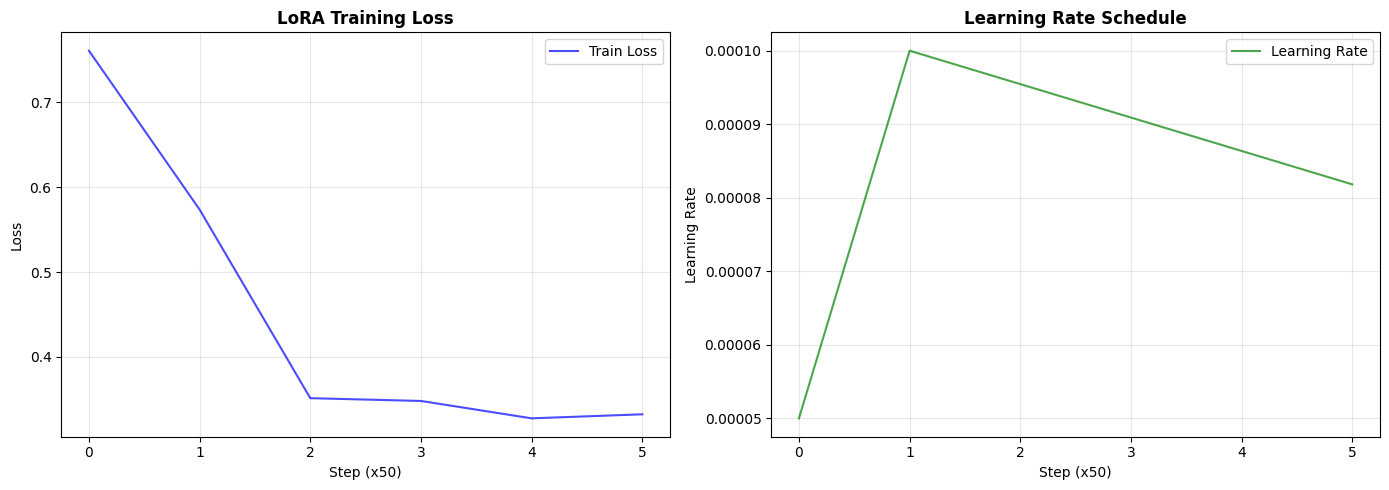


📊 LoRA Training Statistics:
Final Train Loss: 0.3324
Final Val Loss:   0.3479


In [14]:
# Visualizzazione training LoRA
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training loss
axes[0].plot(lora_training_stats['train_loss'], label='Train Loss', color='blue', alpha=0.7)
axes[0].set_xlabel('Step (x50)')
axes[0].set_ylabel('Loss')
axes[0].set_title('LoRA Training Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Learning rate
axes[1].plot(lora_training_stats['learning_rates'], label='Learning Rate', color='green', alpha=0.7)
axes[1].set_xlabel('Step (x50)')
axes[1].set_ylabel('Learning Rate')
axes[1].set_title('Learning Rate Schedule', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 LoRA Training Statistics:")
print(f"Final Train Loss: {lora_training_stats['train_loss'][-1]:.4f}")
if lora_training_stats['val_loss']:
    print(f"Final Val Loss:   {lora_training_stats['val_loss'][-1]:.4f}")

## 🎯 Inference e Evaluation del Modello LoRA Fine-tunato

In [15]:
def _parse_json_response_lora(response: str) -> List[Dict[str, str]]:
    """
    Rimuove token non-JSON dall'output e parsa il risultato.
    """
    import re

    try:
        # Step 1: Rimuovi markdown
        response = response.replace('```json', '').replace('```', '').strip()

        # Step 2: Trova tutti gli array JSON
        candidates = re.findall(r'\[[\s\S]*?\]', response)

        for json_str in candidates:
            try:
                result = json.loads(json_str)

                if isinstance(result, list) and len(result) > 0:
                    normalized = []
                    seen = set()

                    for item in result:
                        if not isinstance(item, dict):
                            continue

                        aspect = str(item.get('aspect', item.get('Aspect', 'NULL'))).strip()
                        category = str(item.get('category', item.get('Category', 'RESTAURANT#GENERAL'))).strip().upper()
                        opinion = str(item.get('opinion', item.get('Opinion', 'NULL'))).strip()

                        if not aspect:
                            aspect = 'NULL'
                        if not opinion:
                            opinion = 'NULL'
                        if not category or category == 'NULL':
                            category = 'RESTAURANT#GENERAL'

                        # Rimuovi duplicati
                        triplet_key = (aspect.lower(), category, opinion.lower())
                        if triplet_key not in seen:
                            seen.add(triplet_key)
                            normalized.append({
                                'Aspect': aspect,
                                'Category': category,
                                'Opinion': opinion
                            })

                    if normalized:
                        return normalized

            except json.JSONDecodeError:
                continue

        # Fallback
        return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

    except Exception:
        return [{'Aspect': 'NULL', 'Category': 'RESTAURANT#GENERAL', 'Opinion': 'NULL'}]

def generate_aoc_with_lora(text: str, model, tokenizer, max_new_tokens: int = 150):
    """Genera AOC per un testo usando il modello LoRA fine-tunato."""
    prompt = create_prompt_for_training(text)

    inputs = tokenizer(prompt, return_tensors='pt', truncation=True, max_length=4096)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    # Decodifica solo la parte generata
    input_length = inputs['attention_mask'][0].sum().item()
    generated_ids = outputs[0][input_length:]
    response = tokenizer.decode(generated_ids, skip_special_tokens=True).strip()

    # Parsa JSON
    aocs = _parse_json_response_lora(response)

    return aocs, response

print("✅ Funzioni di inference per LoRA definite")

✅ Funzioni di inference per LoRA definite


In [16]:
# Test su esempi
print("\n" + "="*80)
print("🎯 TEST INFERENCE MODELLO LoRA")
print("="*80)

test_texts = [
    "The food was amazing but the service was slow.",
    "I love this restaurant! Great atmosphere and delicious pizza.",
    "The prices are too high for the quality you get."
]

for i, text in enumerate(test_texts, 1):
    print(f"\n--- Test {i} ---")
    print(f"Text: {text}")

    aocs, raw_response = generate_aoc_with_lora(text, lora_model, lora_tokenizer)

    print(f"\nRaw response: {raw_response}")
    print(f"\nParsed AOCs:")
    for aoc in aocs:
        print(f"  - Aspect: '{aoc['Aspect']}', Category: '{aoc['Category']}', Opinion: '{aoc['Opinion']}'")

print("\n" + "="*80)

The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



🎯 TEST INFERENCE MODELLO LoRA

--- Test 1 ---
Text: The food was amazing but the service was slow.

Raw response: [{"aspect": "food", "category": "FOOD#QUALITY", "opinion": "amazing"}, {"aspect": "service", "category": "SERVICE#GENERAL", "opinion": "slow"}]

Parsed AOCs:
  - Aspect: 'food', Category: 'FOOD#QUALITY', Opinion: 'amazing'
  - Aspect: 'service', Category: 'SERVICE#GENERAL', Opinion: 'slow'

--- Test 2 ---
Text: I love this restaurant! Great atmosphere and delicious pizza.

Raw response: [{"aspect": "atmosphere", "category": "AMBIENCE#GENERAL", "opinion": "great"}, {"aspect": "pizza", "category": "FOOD#QUALITY", "opinion": "delicious"}]

Parsed AOCs:
  - Aspect: 'atmosphere', Category: 'AMBIENCE#GENERAL', Opinion: 'great'
  - Aspect: 'pizza', Category: 'FOOD#QUALITY', Opinion: 'delicious'

--- Test 3 ---
Text: The prices are too high for the quality you get.

Raw response: [{"aspect": "NULL", "category": "RESTAURANT#PRICES", "opinion": "too high"}, {"aspect": "NULL", "categ

In [17]:
def evaluate_lora_model(model, tokenizer, dataset: List[Dict], num_samples: int = 100):
    """
    Valuta il modello LoRA su un dataset.
    Calcola Precision, Recall, F1 per triplet matching.
    """
    print(f"\n{'='*80}")
    print(f"📊 EVALUATION MODELLO LoRA")
    print(f"{'='*80}")
    print(f"Num samples: {num_samples}")

    sample_data = dataset[:num_samples]

    total_tp = 0
    total_pred = 0
    total_gold = 0

    for item in tqdm(sample_data, desc="Evaluating LoRA"):
        text = item['Text']
        gold_quadruplets = item['Quadruplet']

        # Predizione
        pred_aocs, _ = generate_aoc_with_lora(text, model, tokenizer)

        # Normalizza gold
        gold_triplets = [
            {
                'aspect': q['Aspect'].strip().lower(),
                'category': q['Category'].strip().upper(),
                'opinion': q['Opinion'].strip().lower()
            }
            for q in gold_quadruplets
        ]

        # Normalizza pred
        pred_triplets = [
            {
                'aspect': p['Aspect'].strip().lower(),
                'category': p['Category'].strip().upper(),
                'opinion': p['Opinion'].strip().lower()
            }
            for p in pred_aocs
        ]

        total_gold += len(gold_triplets)
        total_pred += len(pred_triplets)

        # Match
        matched_gold = set()
        for pred in pred_triplets:
            for j, gold in enumerate(gold_triplets):
                if j in matched_gold:
                    continue
                if (pred['aspect'] == gold['aspect'] and
                    pred['category'] == gold['category'] and
                    pred['opinion'] == gold['opinion']):
                    total_tp += 1
                    matched_gold.add(j)
                    break

    # Calcola metriche
    precision = total_tp / total_pred if total_pred > 0 else 0
    recall = total_tp / total_gold if total_gold > 0 else 0
    f1 = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    print(f"\n{'='*80}")
    print(f"📈 RISULTATI LoRA")
    print(f"{'='*80}")
    print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
    print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
    print(f"F1 Score:  {f1:.4f} ({f1*100:.2f}%)")
    print(f"\nTrue Positives:  {total_tp}")
    print(f"Total Predicted: {total_pred}")
    print(f"Total Gold:      {total_gold}")
    print(f"{'='*80}")

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'tp': total_tp,
        'total_pred': total_pred,
        'total_gold': total_gold
    }

# Evalua su validation set
lora_val_results = evaluate_lora_model(lora_model, lora_tokenizer, val_split_data, num_samples=100)


📊 EVALUATION MODELLO LoRA
Num samples: 100


Evaluating LoRA:   0%|          | 0/100 [00:00<?, ?it/s]


📈 RISULTATI LoRA
Precision: 0.5924 (59.24%)
Recall:    0.5776 (57.76%)
F1 Score:  0.5849 (58.49%)

True Positives:  93
Total Predicted: 157
Total Gold:      161


In [ ]:
# Evalua anche su test set
lora_test_results = evaluate_lora_model(lora_model, lora_tokenizer, test_split_data, num_samples=100)

# Confronto risultati
print("\n" + "="*80)
print("📊 CONFRONTO RISULTATI LoRA: VALIDATION vs TEST")
print("="*80)
print(f"\n{'Split':<15} {'Precision':<12} {'Recall':<12} {'F1 Score':<12}")
print("-" * 80)
print(f"{'Validation':<15} {lora_val_results['precision']:<12.4f} {lora_val_results['recall']:<12.4f} {lora_val_results['f1']:<12.4f}")
print(f"{'Test':<15} {lora_test_results['precision']:<12.4f} {lora_test_results['recall']:<12.4f} {lora_test_results['f1']:<12.4f}")
print("="*80)


📊 EVALUATION MODELLO LoRA
Num samples: 100


Evaluating LoRA:   0%|          | 0/100 [00:00<?, ?it/s]


📈 RISULTATI LoRA
Precision: 0.5430 (54.30%)
Recall:    0.5503 (55.03%)
F1 Score:  0.5467 (54.67%)

True Positives:  82
Total Predicted: 151
Total Gold:      149

📊 CONFRONTO RISULTATI LoRA: VALIDATION vs TEST

Split           Precision    Recall       F1 Score    
--------------------------------------------------------------------------------
Validation      0.5924       0.5776       0.5849      
Test            0.5430       0.5503       0.5467      


---

## 🎉 Riepilogo Implementazione LoRA

### ✅ Implementato:

1. **LoRA fine-tuning** di LLAMA 3.2-3B
2. **Cross-entropy loss** token-level
3. **Masking del prompt** (loss solo sul target JSON)
4. **Training loop** custom con validation
5. **Checkpointing** per salvare/caricare modelli
6. **Evaluation** con Precision/Recall/F1 su validation e test set

### 📊 Metriche Valutate:

- **Precision**: % di predizioni corrette
- **Recall**: % di gold standard trovati  
- **F1 Score**: media armonica di Precision e Recall

### 🔄 Integrazione con il Notebook:

Tutte le celle successive del notebook sono state modificate per utilizzare il **modello LoRA fine-tunato** invece del modello LLAMA base:

- ✅ `AspectOpinionCategoryExtractor` ora supporta sia modelli base che LoRA
- ✅ Celle di test usano `lora_model` e `lora_tokenizer`
- ✅ Evaluation usa automaticamente il modello LoRA
- ✅ `OptimizedDimABSAPipeline` integrata con LoRA
- ✅ Generazione submission file usa il modello fine-tunato

### 🚀 Vantaggi del Fine-tuning LoRA:

- **Miglior accuratezza** sull'estrazione AOC specifica per il dominio restaurant
- **Training efficiente** (solo ~1% dei parametri trainabili)
- **Memoria ridotta** (adapter LoRA leggeri)
- **Velocità preservata** (stessa velocità di inference)

### 📝 Come Usare:

1. **Training**: Esegui le celle dalla sezione "LoRA Fine-tuning Configuration"
2. **Inference**: Le celle successive useranno automaticamente il modello fine-tunato
3. **Caricamento checkpoint**: Usa `load_lora_checkpoint()` per caricare modelli salvati

---